In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import seaborn as sns


# Load and Preprocess Data 

In [18]:
df = pd.read_csv('balanced_dataset.csv')

# Modify labels: 0 -> 1, others (1,2,3,4) -> 0
df['label'] = df['label'].apply(lambda x: 0 if x == 1 else 1)


# Preprocess data
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=['label']))
y = df['label'].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# Convert to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([1050, 14]) torch.Size([450, 14]) torch.Size([1050]) torch.Size([450])


# ANFIS Model

In [19]:
class ANFIS(nn.Module):
    def __init__(self, input_dim, num_rules):
        super(ANFIS, self).__init__()
        self.num_rules = num_rules
        
        # Fuzzy Membership Parameters (Gaussian functions) - Ensuring Stability
        self.mu = nn.Parameter(torch.randn(input_dim, num_rules))
        self.sigma = nn.Parameter(torch.randn(input_dim, num_rules).abs() + 1e-6)  # Avoiding zero sigma
        
        # Output Layer
        self.linear = nn.Linear(num_rules, 1)  # Single output for binary classification
    
    def forward(self, x):
        # Gaussian Membership Functions - Adding Stability
        membership = torch.exp(-((x.unsqueeze(2) - self.mu) ** 2) / (2 * self.sigma ** 2 + 1e-6))
        
        # Rule Activation (Product of Memberships)
        rule_activation = torch.prod(membership, dim=1)
        
        # Normalize Rule Activations - Prevent Division by Zero
        sum_activation = torch.sum(rule_activation, dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        rule_strengths = rule_activation / sum_activation
        
        # Weighted Rule Outputs
        output = self.linear(rule_strengths)
        
        return torch.sigmoid(output).squeeze()  # Apply sigmoid for binary classification

# Initialize model
input_dim = X_train.shape[1]
num_rules = 5  # Number of fuzzy rules
model = ANFIS(input_dim, num_rules)


# training

In [20]:
class_weight = torch.tensor([len(y_train[y_train == 0]) / len(y_train[y_train == 1])])
criterion = nn.BCELoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop
num_epochs = 3000  # Increase training epochs for better convergence
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)  # Use adjusted loss function
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/3500], Loss: 1.0736
Epoch [20/3500], Loss: 1.0693
Epoch [30/3500], Loss: 1.0651
Epoch [40/3500], Loss: 1.0601
Epoch [50/3500], Loss: 1.0509
Epoch [60/3500], Loss: 1.0266
Epoch [70/3500], Loss: 1.0005
Epoch [80/3500], Loss: 0.9951
Epoch [90/3500], Loss: 0.9846
Epoch [100/3500], Loss: 0.9771
Epoch [110/3500], Loss: 0.9675
Epoch [120/3500], Loss: 0.9572
Epoch [130/3500], Loss: 0.9475
Epoch [140/3500], Loss: 0.9393
Epoch [150/3500], Loss: 0.9326
Epoch [160/3500], Loss: 0.9270
Epoch [170/3500], Loss: 0.9221
Epoch [180/3500], Loss: 0.9177
Epoch [190/3500], Loss: 0.9137
Epoch [200/3500], Loss: 0.9099
Epoch [210/3500], Loss: 0.9064
Epoch [220/3500], Loss: 0.9031
Epoch [230/3500], Loss: 0.9000
Epoch [240/3500], Loss: 0.8969
Epoch [250/3500], Loss: 0.8939
Epoch [260/3500], Loss: 0.8910
Epoch [270/3500], Loss: 0.8881
Epoch [280/3500], Loss: 0.8852
Epoch [290/3500], Loss: 0.8823
Epoch [300/3500], Loss: 0.8793
Epoch [310/3500], Loss: 0.8761
Epoch [320/3500], Loss: 0.8728
Epoch [330/3500],

Test Loss: 0.4140
Precision: 0.8771


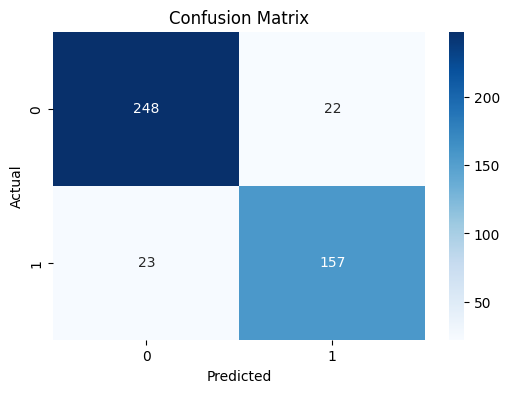

Confusion Matrix:
[[248  22]
 [ 23 157]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       270
         1.0       0.88      0.87      0.87       180

    accuracy                           0.90       450
   macro avg       0.90      0.90      0.90       450
weighted avg       0.90      0.90      0.90       450



In [21]:
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Convert predictions to binary labels
y_pred_class = (y_pred > 0.5).int().numpy()
y_test_numpy = y_test.numpy()

# Calculate precision
precision = precision_score(y_test_numpy, y_pred_class, average='binary', zero_division=1)
print(f'Precision: {precision:.4f}')

conf_matrix = confusion_matrix(y_test_numpy, y_pred_class)
# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
# Generate confusion matrix

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_numpy, y_pred_class, zero_division=1))

# Testing

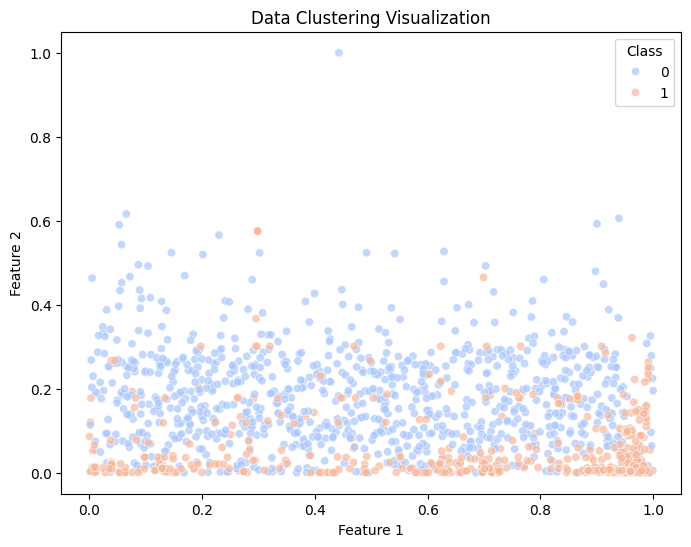

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Clustering Visualization')
plt.legend(title='Class')
plt.show()

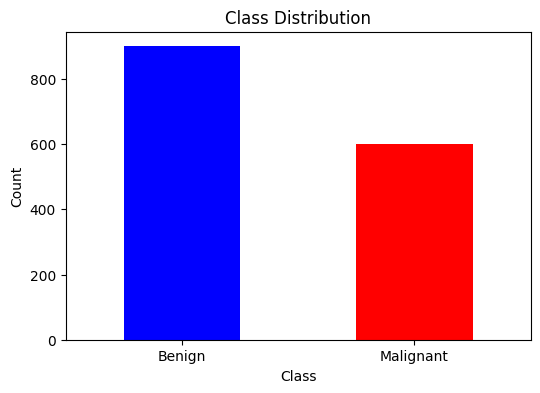

In [23]:
plt.figure(figsize=(6, 4))
class_counts = pd.Series(y).value_counts()
class_counts.plot(kind='bar', color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malignant'], rotation=0)
plt.show()

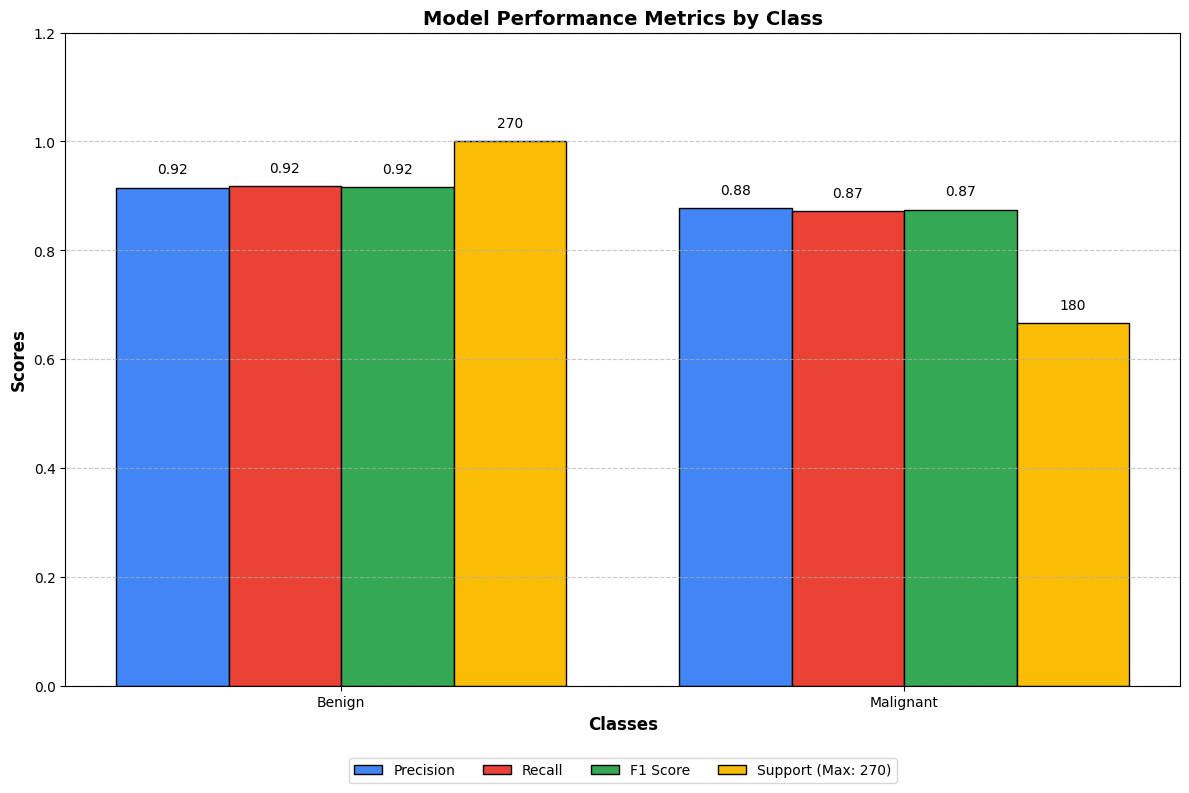

In [25]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Calculate precision, recall, f1-score and support for each class
precision, recall, f1, support = precision_recall_fscore_support(y_test_numpy, y_pred_class, zero_division=1)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Set width of bar and positions
barWidth = 0.2
r1 = np.arange(len(precision))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Create bars
ax.bar(r1, precision, width=barWidth, label='Precision', color='#4285F4', edgecolor='black')
ax.bar(r2, recall, width=barWidth, label='Recall', color='#EA4335', edgecolor='black')
ax.bar(r3, f1, width=barWidth, label='F1 Score', color='#34A853', edgecolor='black')

# For support, we need to normalize it since it could be much larger
max_support = max(support)
normalized_support = [s/max_support for s in support]
ax.bar(r4, normalized_support, width=barWidth, label=f'Support (Max: {max_support})', color='#FBBC05', edgecolor='black')

# Add labels and title
plt.xlabel('Classes', fontweight='bold', fontsize=12)
plt.ylabel('Scores', fontweight='bold', fontsize=12)
plt.xticks([r + barWidth*1.5 for r in range(len(precision))], ['Benign', 'Malignant'])
plt.title('Model Performance Metrics by Class', fontweight='bold', fontsize=14)

# Add value labels on top of bars
for i, r_list in enumerate([r1, r2, r3]):
    for j, r_val in enumerate(r_list):
        values = [precision, recall, f1]
        plt.text(r_val, values[i][j] + 0.02, f'{values[i][j]:.2f}', ha='center', va='bottom', fontsize=10)

# For support, add the actual values
for i, r_val in enumerate(r4):
    plt.text(r_val, normalized_support[i] + 0.02, f'{support[i]}', ha='center', va='bottom', fontsize=10)

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

# Adjust layout and display
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.2)  # Set y-axis limit with some padding for text
plt.show()

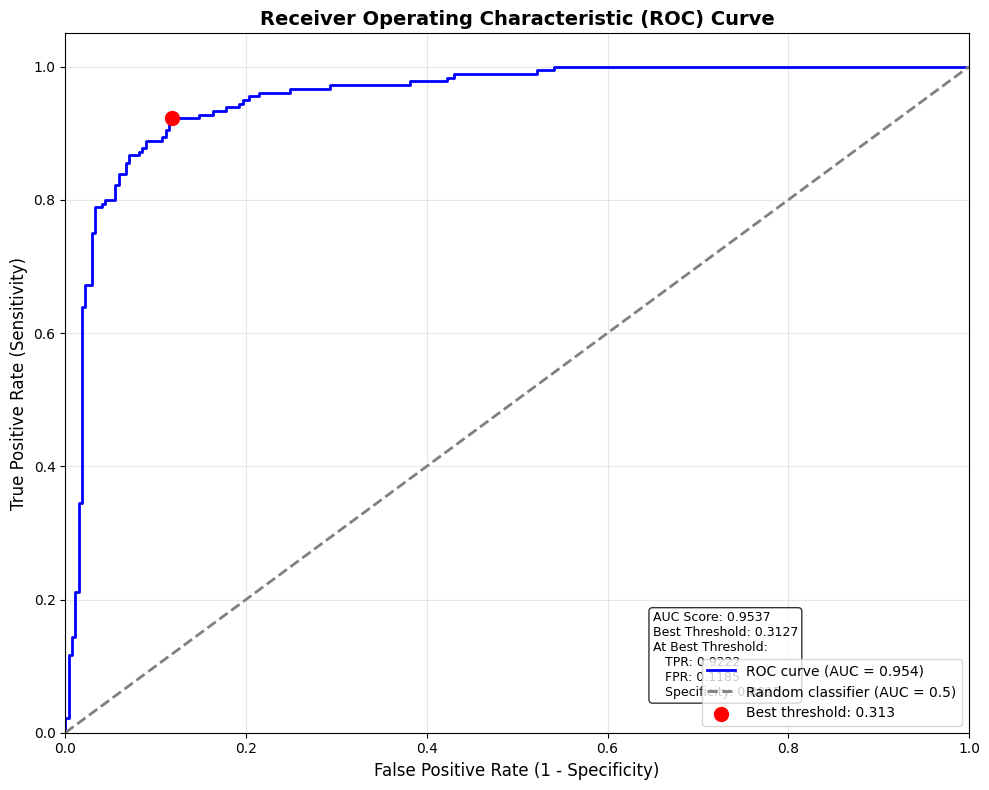

ROC AUC Score: 0.9537
Best threshold: 0.3127


In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(model, X_test, y_test, figsize=(10, 8)):
    """
    Plots the ROC curve for the given model and calculates the AUC score.
    
    Args:
        model: The trained model with a predict method
        X_test: Test features
        y_test: True labels for test data
        figsize: Figure size as a tuple (width, height)
    """
    # Convert inputs to appropriate format if needed
    if isinstance(X_test, np.ndarray):
        X_test = torch.tensor(X_test, dtype=torch.float32)
    
    if X_test.dim() == 1:
        X_test = X_test.unsqueeze(0)
        
    # Get probability predictions
    with torch.no_grad():
        y_pred_prob = model(X_test).numpy().flatten()
    
    # Get true labels as numpy array
    y_test_numpy = y_test.numpy() if isinstance(y_test, torch.Tensor) else np.array(y_test)
    
    # Calculate ROC curve points and AUC
    fpr, tpr, thresholds = roc_curve(y_test_numpy, y_pred_prob)
    auc_score = roc_auc_score(y_test_numpy, y_pred_prob)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, 
             label=f'ROC curve (AUC = {auc_score:.3f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2,
             label='Random classifier (AUC = 0.5)')
    
    # Highlight key points
    best_threshold_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_threshold_idx]
    best_fpr, best_tpr = fpr[best_threshold_idx], tpr[best_threshold_idx]
    
    plt.scatter(best_fpr, best_tpr, color='red', s=100, zorder=3,
                label=f'Best threshold: {best_threshold:.3f}')
    
    # Formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True, alpha=0.3)
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    
    # Add detailed info text box
    textstr = '\n'.join((
        f'AUC Score: {auc_score:.4f}',
        f'Best Threshold: {best_threshold:.4f}',
        f'At Best Threshold:',
        f'   TPR: {best_tpr:.4f}',
        f'   FPR: {best_fpr:.4f}',
        f'   Specificity: {1-best_fpr:.4f}'
    ))
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.text(0.65, 0.05, textstr, fontsize=9,
             verticalalignment='bottom', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics for further analysis if needed
    return {
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'auc': auc_score,
        'best_threshold': best_threshold
    }

# Generate the ROC curve for your model
roc_results = plot_roc_curve(model, X_test, y_test)

# Print key metrics
print(f"ROC AUC Score: {roc_results['auc']:.4f}")
print(f"Best threshold: {roc_results['best_threshold']:.4f}")